Traddif light classifier learning

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

In [2]:
#Load data list
PATH_IMG_LIST_CSV="../ros/src/tl_detector/training_data/data.csv"
PATH_IMG_DIR="../ros/src/tl_detector"
img_list_csv=pd.read_csv(PATH_IMG_LIST_CSV,sep=',',header=None)
cls=img_list_csv[1]
filenames=img_list_csv[0]
data_num=len(cls)

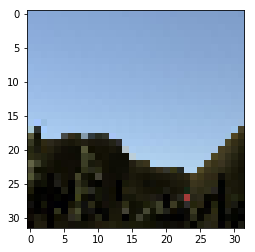

In [6]:
#Test resizing
fn=filenames[726]
image_bgr = cv2.imread(PATH_IMG_DIR+"/"+fn)
image=cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image.astype(np.uint8))
plt.imshow(cv2.resize(image,(32,32)).astype(np.uint8))

In [7]:
#Parameters
batch_size=32
learning_rate=1e-4
resized_width=32
resized_height=32

In [8]:
#Load images
#resize 600,800->32,32

data=np.zeros([filenames.shape[0],resized_height,resized_width,3])
for i,fn in enumerate(filenames):
    image_bgr = cv2.imread(PATH_IMG_DIR+"/"+fn)
    image=cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
    data[i,:,:,:]=cv2.resize(image,(resized_height,resized_width))

In [9]:
#Split data

#Shuffle data
np.random.seed(0)
shuffle_idx=np.random.permutation(cls.shape[0])

#Split data indices
train_num=int(data_num*0.6)
test_num=int(data_num*0.2)
val_num=data_num-train_num-test_num
train_idx=shuffle_idx[:train_num]
test_idx=shuffle_idx[train_num:train_num+test_num]
val_idx=shuffle_idx[train_num+test_num:]

#Save indices
np.savetxt("dataset_train.csv",train_idx)
np.savetxt("dataset_test.csv",test_idx)
np.savetxt("dataset_val.csv",val_idx)

#Split data
train_cls=cls[train_idx]
train_data=data[train_idx]
test_cls=cls[test_idx]
test_data=data[test_idx]
val_cls=cls[val_idx]
val_data=data[val_idx]

In [10]:
#Define model

#Input
x_input_shape=(None,resized_width,resized_height,3)
y_input_shape=(None,)
x_input=tf.placeholder(tf.float32,shape=x_input_shape,name="x_input")
y_input=tf.placeholder(tf.int32,shape=y_input_shape,name="y_input")
y_input_onehot=tf.one_hot(y_input, depth=3, dtype=tf.float32)

#conv 1
#32*32 -> 32*32 *32
conv1_w=tf.Variable(tf.truncated_normal([3,3,3,32]))
conv1_b=tf.Variable(tf.truncated_normal([32]))

conv1_c=tf.nn.conv2d(x_input,conv1_w,strides=[1,1,1,1], padding='SAME')+conv1_b
conv1_a=tf.nn.relu(conv1_c)

#pool 1
#32*32*32-> 16*16*32
pool1=tf.nn.max_pool(conv1_a, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#conv 2
#16*16*32 -> 16*16*64
conv2_w=tf.Variable(tf.truncated_normal([3,3,32,64]))
conv2_b=tf.Variable(tf.truncated_normal([64]))

conv2_c=tf.nn.conv2d(pool1,conv2_w,strides=[1,1,1,1], padding='SAME')+conv2_b
conv2_a=tf.nn.relu(conv2_c)

#pool 1
#16*16*64 -> 8*8*64
pool2=tf.nn.max_pool(conv2_a, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#fc
#8*8*64 ->3
fc1_w=tf.Variable(tf.truncated_normal([8*8*64,3]))
fc1_b=tf.Variable(tf.truncated_normal([3]))

fc1_in=tf.reshape(pool2,[-1,8*8*64])
fc1_c=tf.matmul(fc1_in,fc1_w)+fc1_b

#Prediction, accuracy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_input_onehot, logits=fc1_c))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
prediction=tf.argmax(fc1_c, 1,name="prediction")
correct_prediction = tf.equal(prediction, tf.argmax(y_input_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="accuracy")

In [11]:
#Model test
tf.set_random_seed(0)
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for j in range(400):
        for i in range(int(train_data.shape[0]/batch_size)):
            start_idx=i*batch_size
            end_idx=min((i+1)*batch_size,data.shape[0]-1)
            cur_x=train_data[start_idx:end_idx,:,:,:]
            cur_y=train_cls[start_idx:end_idx]
            train_step.run(feed_dict={x_input: cur_x, y_input: cur_y})
        if j % 20==0:
            train_accuracy=accuracy.eval(feed_dict={x_input: cur_x, y_input: cur_y})
            test_accuracy=accuracy.eval(feed_dict={x_input: test_data, y_input: test_cls})
            print('epoch %d, train acc %f  test acc %f' % (j, train_accuracy,test_accuracy))

    print('validation acc %g' % accuracy.eval(feed_dict={x_input: val_data, y_input: val_cls}))

epoch 0, train acc 0.312500  test acc 0.418269
epoch 20, train acc 0.781250  test acc 0.673077
epoch 40, train acc 0.843750  test acc 0.750000
epoch 60, train acc 0.781250  test acc 0.802885
epoch 80, train acc 0.875000  test acc 0.831731
epoch 100, train acc 0.968750  test acc 0.860577
epoch 120, train acc 0.968750  test acc 0.884615
epoch 140, train acc 1.000000  test acc 0.865385
epoch 160, train acc 1.000000  test acc 0.908654
epoch 180, train acc 0.968750  test acc 0.903846
epoch 200, train acc 1.000000  test acc 0.937500
epoch 220, train acc 1.000000  test acc 0.947115
epoch 240, train acc 1.000000  test acc 0.947115
epoch 260, train acc 1.000000  test acc 0.947115
epoch 280, train acc 1.000000  test acc 0.947115
epoch 300, train acc 1.000000  test acc 0.947115
epoch 320, train acc 1.000000  test acc 0.947115
epoch 340, train acc 1.000000  test acc 0.947115
epoch 360, train acc 1.000000  test acc 0.947115
epoch 380, train acc 1.000000  test acc 0.947115
validation acc 0.933014


In [12]:
#Training final model (using all data)
tf.set_random_seed(0)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    count=0
    for j in range(400):
        for i in range(int(data.shape[0]/batch_size)):
            count+=1
            start_idx=i*batch_size
            end_idx=min((i+1)*batch_size,data.shape[0]-1)
            cur_x=data[start_idx:end_idx,:,:,:]
            cur_y=cls[start_idx:end_idx]
            train_step.run(feed_dict={x_input: cur_x, y_input: cur_y})
        if j % 20==0:
            train_accuracy = accuracy.eval(feed_dict={x_input: cur_x, y_input: cur_y})
            print('epoch %d, training accuracy %g' % (j, train_accuracy))

    print('all data accuracy %g' % accuracy.eval(feed_dict={x_input: data, y_input: cls}))
    predicted_cls=prediction.eval(feed_dict={x_input: data})
    
    #Save model
    save_path = saver.save(sess, "./tl_classifier.ckpt")

epoch 0, training accuracy 0
epoch 20, training accuracy 0.03125
epoch 40, training accuracy 0.21875
epoch 60, training accuracy 0.3125
epoch 80, training accuracy 0.40625
epoch 100, training accuracy 0.625
epoch 120, training accuracy 0.59375
epoch 140, training accuracy 0.84375
epoch 160, training accuracy 0.875
epoch 180, training accuracy 0.875
epoch 200, training accuracy 0.8125
epoch 220, training accuracy 0.90625
epoch 240, training accuracy 0.96875
epoch 260, training accuracy 0.96875
epoch 280, training accuracy 0.90625
epoch 300, training accuracy 0.90625
epoch 320, training accuracy 0.96875
epoch 340, training accuracy 0.96875
epoch 360, training accuracy 0.96875
epoch 380, training accuracy 0.96875
all data accuracy 1


In [13]:
#Loading test
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("tl_classifier.ckpt.meta")
    saver.restore(sess, "./tl_classifier.ckpt")
    x_input=sess.graph.get_tensor_by_name("x_input:0")
    y_input=sess.graph.get_tensor_by_name("y_input:0")
    prediction=sess.graph.get_tensor_by_name("prediction:0")
    accuracy=sess.graph.get_tensor_by_name("accuracy:0")
    print('all data accuracy %g' % accuracy.eval(feed_dict={x_input: data.astype(np.float64), y_input: cls}))

INFO:tensorflow:Restoring parameters from ./tl_classifier.ckpt
all data accuracy 1
